# Tensor
- http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html

In [1]:
import sys

import torch
import numpy as np

print(sys.version)
print(torch.__version__)
print(np.__version__)

3.6.0 |Anaconda 4.3.0 (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
0.2.0_4
1.11.3


In [2]:
x = torch.rand(5, 3)
y = torch.rand(5, 3)
print(x.size())

torch.Size([5, 3])


### Operation that mutates a tensor in-place is post-fixed with an _

In [3]:
print(x.t_())


 0.0606  0.0732  0.3660  0.6655  0.3435
 0.5989  0.1987  0.5833  0.1860  0.9380
 0.2718  0.2222  0.6606  0.2860  0.7075
[torch.FloatTensor of size 3x5]



### Indexing

In [4]:
print(x[:, 1])


 0.0732
 0.1987
 0.2222
[torch.FloatTensor of size 3]



### Torch Tensor <-> Numpy Array

In [5]:
print(x.numpy())

[[ 0.06064637  0.07318518  0.36599004  0.66552782  0.34350985]
 [ 0.59887272  0.19872743  0.58325714  0.18602231  0.93800735]
 [ 0.27184233  0.22218503  0.66061127  0.2859588   0.70750552]]


In [6]:
print(torch.from_numpy(np.ones(5)))


 1
 1
 1
 1
 1
[torch.DoubleTensor of size 5]



### CUDA Tensor

In [7]:
# dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor
print(torch.cuda.is_available())

True


In [8]:
x = x.cuda()
y = y.cuda()
print(x + y)


 0.7047  0.4330  0.6873  1.1491  0.3624
 1.1563  1.0986  1.1442  0.7165  1.4952
 0.6273  1.1611  1.4313  1.1697  1.3826
[torch.cuda.FloatTensor of size 3x5 (GPU 0)]



---
# Autograd
- http://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

### Variable
- Access raw data (i.e., Tensor) through ```.data```, gradient through ```.grad``` attribute
- ```.backward()``` does back propagation
- Variable defined a computational graph, allowing to automatically compute gradients

In [9]:
from torch.autograd import Variable

x = Variable(torch.ones(2, 2), requires_grad=True)
y = x + 2
z = y * y * 3
o = z.mean()
o.backward()
print(o.grad)    # why None?
print(o.data)

None

 27
[torch.FloatTensor of size 1]



---
# Neural Networks
- http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
# Define Network
model = torch.nn.Sequential(    # sample DNN
    torch.nn.Linear(64, 100),    # input, hidden
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),    # hidden, output
)

class SampleNet(nn.Module):    # sample CNN
    
    def __init__(self, channels=1):    # define layers with weights
        super(SampleNet, self).__init__()
        self.conv1 = nn.Conv2d(channels, 6, (5, 5))    # 1 input channel, 6 output channel, 5*5 kernel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, (5, 5))
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_features(x))    # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_features(self, x):
        size = x.size()[1:]    # except batch dimension
        n = 1
        for s in size:
            n *= s
        return n        

In [12]:
net = SampleNet()
print(net)

SampleNet (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [13]:
# Forward
x = Variable(torch.randn(1, 1, 32, 32))    # NCHW
# Input:  1, 32, 32
# Conv1:  6, 28, 28
# Pool1:  6, 14, 14
# Conv2: 16, 10, 10
# Pool2: 16,  5,  5
# FC1:   400 -> 120
# FC2:   120 ->  84
# FC3:    84 ->  10
y_h = net(x)
print(y_h)

Variable containing:
-0.0288  0.0393 -0.0016  0.0575  0.0665  0.0776  0.0366 -0.0333  0.1360  0.0520
[torch.FloatTensor of size 1x10]



In [14]:
# Backward
optimizer = optim.Adam(net.parameters(), lr=1e-3)
optimizer.zero_grad()    # flush gradient buffer
y = Variable(torch.arange(1, 11))    # dummy
criterion = nn.MSELoss()
loss = criterion(y_h, y)
print(loss)
loss.backward()    # calc gradients
optimizer.step()    # update weight

Variable containing:
 37.9427
[torch.FloatTensor of size 1]



### Save/Load Model
- https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610

In [15]:
torch.save(net.state_dict(), './model.pt')    # recommended
model.load_state_dict(torch.load('./model.pt'))
torch.save(net, './model.pt')
model = torch.load('./model.pt')

---
# CIFAR10
- http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [17]:
# Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,.5,.5), (.5,.5,.5))])
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# Model
net = SampleNet(channels=3)
net.cuda()    # use GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [19]:
# Train
for epoch in range(10):
    _loss = .0
    for step, (x, y) in enumerate(trainloader, 1):
        x, y = Variable(x.cuda()), Variable(y.cuda())
        optimizer.zero_grad()
        y_h = net(x)
        loss = criterion(y_h, y)
        loss.backward()
        optimizer.step()
        _loss += loss.data[0]    # loss itself is not scalar
        if step % 4000 == 0:
            print('Epoch={} Step={} Loss={}'.format(epoch+1, step, _loss))
            _loss = .0

Epoch=1 Step=4000 Loss=7127.154998
Epoch=1 Step=8000 Loss=6049.67474911
Epoch=1 Step=12000 Loss=5684.34711048
Epoch=2 Step=4000 Loss=5371.61085331
Epoch=2 Step=8000 Loss=5157.32687739
Epoch=2 Step=12000 Loss=5073.66945606
Epoch=3 Step=4000 Loss=4819.9245549
Epoch=3 Step=8000 Loss=4857.22655977
Epoch=3 Step=12000 Loss=4744.05268879
Epoch=4 Step=4000 Loss=4478.69756831
Epoch=4 Step=8000 Loss=4575.83774575
Epoch=4 Step=12000 Loss=4542.27432359
Epoch=5 Step=4000 Loss=4259.81654188
Epoch=5 Step=8000 Loss=4371.06160181
Epoch=5 Step=12000 Loss=4387.04552899
Epoch=6 Step=4000 Loss=4077.10606264
Epoch=6 Step=8000 Loss=4162.47280564
Epoch=6 Step=12000 Loss=4315.80315044
Epoch=7 Step=4000 Loss=3970.78053682
Epoch=7 Step=8000 Loss=4092.53653866
Epoch=7 Step=12000 Loss=4124.91836635
Epoch=8 Step=4000 Loss=3882.19095669
Epoch=8 Step=8000 Loss=3930.22532056
Epoch=8 Step=12000 Loss=4020.91952044
Epoch=9 Step=4000 Loss=3835.6254763
Epoch=9 Step=8000 Loss=3889.30379331
Epoch=9 Step=12000 Loss=3900.39684

True: frog frog car frog
Pred: deer frog car bird


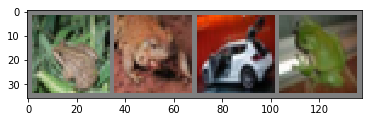

In [20]:
# Test
def imshow(img):
    img = img / 2 + 0.5    # 0-1
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
y_h = net(Variable(images.cuda()))
_, preds = torch.max(y_h.data, 1)    # must be .data else pred becomes Variable
print('True: '+' '.join(map(classes.__getitem__, labels)))
print('Pred: '+' '.join(map(classes.__getitem__, preds.view(-1).tolist())))

In [21]:
# Accuracy (overall)
correct, total = 0, 0
for (images, labels) in testloader:
    y_h = net(Variable(images.cuda()))
    _, preds = torch.max(y_h.data, 1)
    total += labels.size(0)    # size(0): [4] -> 4
    correct += (preds == labels.cuda()).sum()    # true: 1, false: 0
print(correct, total, correct / total)

6082 10000 0.6082


In [22]:
# Accuracy (class)
correct = [0 for _ in range(len(classes))]
total = [0 for _ in range(len(classes))]
for (images, labels) in testloader:
    y_h = net(Variable(images.cuda()))
    _, preds = torch.max(y_h.data, 1)
    tf = (preds == labels.cuda()).squeeze()    # squeeze: 4*1 -> 4
    for i, j in enumerate(labels):
        correct[j] += tf[i]
        total[j] += 1
for i in range(len(classes)):
    print('{:5s}: {:.3f}'.format(classes[i], correct[i] / total[i]))

plane: 0.719
car  : 0.796
bird : 0.496
cat  : 0.316
deer : 0.556
dog  : 0.505
frog : 0.805
horse: 0.613
ship : 0.575
truck: 0.701


---
# Transfer Learning
- http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- Use pretrained ResNet-18 and fine-tune the last layer to classify **ants** and **bees**

In [23]:
# wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!ls data/hymenoptera_data/train/bees | head

1092977343_cb42b38d62.jpg
1093831624_fb5fbe2308.jpg
1097045929_1753d1c765.jpg
1232245714_f862fbe385.jpg
129236073_0985e91c7d.jpg
1295655112_7813f37d21.jpg
132511197_0b86ad0fff.jpg
132826773_dbbcb117b9.jpg
150013791_969d9a968b.jpg
1508176360_2972117c9d.jpg


In [24]:
import copy
import os
import time

from torchvision import datasets, models, transforms

In [25]:
# Preprocess
data_transforms = {
    'train': transforms.Compose([    # augmentation, normalization
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([    # normalization only
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = './data/hymenoptera_data'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print(dset_classes, dset_sizes)

['ants', 'bees'] {'train': 244, 'val': 153}


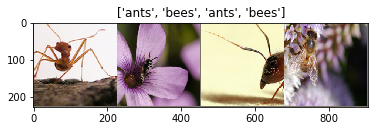

In [26]:
# Samples
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    plt.imshow(img)
    if title is not None:
        plt.title(title)
images, classes = next(iter(dset_loaders['train']))
out = torchvision.utils.make_grid(images)
imshow(out, title=[dset_classes[x] for x in classes])

In [27]:
# Load ResNet-18
resnet = models.resnet18(pretrained=True)
# for param in resnet.parameters():    # freeze parameters
#     param.requires_grad = False
print(resnet.fc.in_features)
print(resnet.fc.out_features)    # original output classes

512
1000


In [28]:
# Reset FC
resnet.fc = nn.Linear(resnet.fc.in_features, len(dset_classes))
resnet = resnet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [29]:
# Train
start = time.time()
best_model = None
best_acc = .0
for epoch in range(10):
    for phase in ('train', 'val'):
        is_train = True if phase == 'train' else False
        resnet.train(is_train)
        epoch_loss = .0
        epoch_acc = .0
        for images, labels in dset_loaders[phase]:
            images, labels = Variable(images.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            y_h = resnet(images)
            _, preds = torch.max(y_h, 1)
            loss = criterion(y_h, labels)
            if is_train:
                loss.backward()
                optimizer.step()
            epoch_loss += loss
            epoch_acc += (preds == labels).float().sum()
        epoch_loss /= dset_sizes[phase]
        epoch_acc /= dset_sizes[phase]
        print('Epoch={:2d} Phase={:5s} Acc={:.4f} Loss={:.4f}'.format(epoch+1, phase, epoch_acc.data[0], epoch_loss.data[0]))
        if not is_train and epoch_acc.data[0] > best_acc:
            best_acc = epoch_acc.data[0]
            best_model = copy.deepcopy(resnet)
elapsed = time.time()-start
print('Elapsed: {}m {}s'.format(elapsed//60, elapsed%60))
print('Best Acc: {}'.format(best_acc))

Epoch= 1 Phase=train Acc=0.6885 Loss=0.1537
Epoch= 1 Phase=val   Acc=0.7124 Loss=0.1462
Epoch= 2 Phase=train Acc=0.7336 Loss=0.1367
Epoch= 2 Phase=val   Acc=0.7516 Loss=0.1291
Epoch= 3 Phase=train Acc=0.7090 Loss=0.1360
Epoch= 3 Phase=val   Acc=0.6928 Loss=0.1822
Epoch= 4 Phase=train Acc=0.7377 Loss=0.1371
Epoch= 4 Phase=val   Acc=0.8039 Loss=0.1268
Epoch= 5 Phase=train Acc=0.7254 Loss=0.1378
Epoch= 5 Phase=val   Acc=0.7320 Loss=0.1417
Epoch= 6 Phase=train Acc=0.6803 Loss=0.1506
Epoch= 6 Phase=val   Acc=0.7843 Loss=0.1285
Epoch= 7 Phase=train Acc=0.7541 Loss=0.1309
Epoch= 7 Phase=val   Acc=0.7516 Loss=0.1542
Epoch= 8 Phase=train Acc=0.7008 Loss=0.1371
Epoch= 8 Phase=val   Acc=0.7582 Loss=0.1479
Epoch= 9 Phase=train Acc=0.7623 Loss=0.1326
Epoch= 9 Phase=val   Acc=0.7712 Loss=0.1452
Epoch=10 Phase=train Acc=0.7418 Loss=0.1333
Epoch=10 Phase=val   Acc=0.7190 Loss=0.1475
Elapsed: 0.0m 25.6179478168s
Best Acc: 0.803921580315
